# Dynamical inter-subjects correlation and Activity Engagement (AE) - figure 2

### Importing functions

In [1]:
import matplotlib as mpl
import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
import seaborn as sns
from utils import split_hemis

#From the toolbox
import saving as sv
import avalanches as av
import Utils_FC as fc
from utils import *

warnings.simplefilter('ignore')

#Here the path to data 
path_results='C:/Users/matte/OneDrive/Documenti/matteo/sorciere_results/'
path_figures='C:/Users/matte/OneDrive/Documenti/matteo/sorciere_results/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'

#colors for plotting 
col_s='#8CCC94'
col_m='#FCAC74'
col_r='#6CA4CC'

colors={}
colors['rest'] = col_r
colors['speech'] = col_s
colors['music'] = col_m

#Here uploading subject and sound list
sound_list=['rest','music','speech']

subject_list = sv.loading(path+'sorciere_utils/sublist')

nsubs=len(subject_list)

cha_i=sv.loading(path+'sorciere_utils/channels_dic_H_non_H_left_right')


### Uploading data, channels and subject list

In [2]:

#PARAMETERS

subject_list=subject_list
final_channels_without_H={}
final_channels_H={}
final_channels_all={}
dataused='all'

zdata={}

for isub, subject in enumerate(subject_list):
    
    zdata[subject]={}
    
    for sound in sound_list:
    
        ## Load the data from the HDF fil
        #print(subject, isub)    
        #Loading the data
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        
        #dictionaries with subjects ad keys and channels names
        final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in cha_i[subject]['non_H']]
        final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in cha_i[subject]['H']]
        final_channels_all[subject]=clean_chnames

        #The final channels that we used
        final_channels=clean_chnames

        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus

        if dataused=='H':
            clean = np.delete(clean, cha_i[subject]['non_H'], axis=0)

        #only the channels not in the helsch gyrus
        elif dataused=='non_H':
            clean = np.delete(clean, cha_i[subject]['H'], axis=0)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)


Computing the activity profile

In [3]:
ap={} #here the activity profile of each subject is stored

for subject in subject_list:
    ap[subject]={}
    avalanches={}
    
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata[subject]['rest'], 99)
    
    for sound in sound_list:
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        ap[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
        

Here we create a matrix, whose lines are AP of different subjects

In [4]:

ap_matrix={} 
for sound in sound_list:
    ap_matrix[sound]=np.zeros((len(subject_list), len(ap[subject_list[0]][sound])))
    for isub, subject in enumerate(subject_list):
        ap_matrix[sound][isub,:]=ap[subject][sound]
    

## COMPUTING THE DYNAMICAL CORREALTION

In [5]:
L = 150 # window length for fitting
sp = 50 # window spacing
dc={}
for sound in sound_list:
    tlen=len(ap_matrix[sound][0])
    W_L = np.arange(0,tlen-int(L),int(sp)) # start times of windows, spaced every sp time points
    n_W = W_L.size # number of windows
    nedges=int(nsubs*(nsubs-1)/2)
    magt=np.zeros((n_W,nedges)) 
    for i in range(n_W):
        t_start = W_L[i]
        t_stop = t_start + L
        dat=ap_matrix[sound][:,t_start:t_stop]
        magt[i,:]=np.corrcoef(dat)[np.triu_indices(nsubs,1)]
    dc[sound]=magt

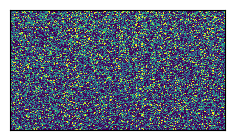

In [6]:
plt.figure(figsize=(2.45,1.5))
#plt.figure(figsize=(2.1,1.35))
ord_s=np.argsort(np.mean(dc['speech'],axis=0))[::-1]
plt.imshow(dc['speech'][:,ord_s].T,cmap='viridis',interpolation='nearest',aspect='auto',vmin=-0.05,vmax=0.2)
#plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(path_results+'DCmat_s.png', transparent=True, dpi=600)
plt.show()

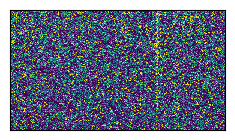

In [7]:
plt.figure(figsize=(2.45,1.5))
#plt.figure(figsize=(2.1,1.35))
ord_m=np.argsort(np.mean(dc['music'],axis=0))[::-1]
plt.imshow(dc['music'][:,ord_m].T,cmap='viridis',interpolation='nearest',aspect='auto',vmin=-0.05,vmax=0.2)
#plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(path_figures+'DCmat_m.pdf', transparent=True, format="PDF")
plt.show()

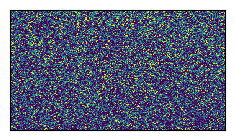

In [8]:
plt.figure(figsize=(2.45,1.5))
#plt.figure(figsize=(2.1,1.35))
ord_r=np.argsort(np.mean(dc['rest'],axis=0))[::-1]
plt.imshow(dc['rest'][:,ord_r].T,cmap='viridis',interpolation='nearest',aspect='auto',vmin=-0.05,vmax=0.2)#plt.xticks([])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig(path_figures+'DCmat_r.pdf', transparent=True, format="PDF")
plt.show()

In [9]:
dc_s=np.mean(dc['speech'],axis=1)[1:]
dc_m=np.mean(dc['music'],axis=1)[1:]
dc_r=np.mean(dc['rest'],axis=1)[1:]

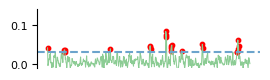

In [10]:
fig, ax = plt.subplots(figsize=(2.8,.9))
ax.plot(dc_s,c=col_s,linewidth=0.75)
ax.axhline(np.max(dc_r),linestyle='--',c=col_r)
ax.scatter(np.where(dc_s>np.max(dc_r))[0],dc_s[np.where(dc_s>np.max(dc_r))],c='r',s=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xticks([])
ax.tick_params(labelsize=8)
ax.set_ylim((-0.01,0.14))
#ax.set_yticks([-75,-50,-25,0,25],['','','','',''])
plt.tight_layout()
plt.savefig(path_figures+'dc_s.pdf', transparent=True, format="PDF")
plt.show()

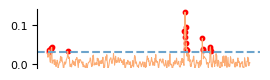

In [11]:
fig, ax = plt.subplots(figsize=(2.8,.9))
ax.plot(dc_m,c=col_m,linewidth=0.75)
ax.axhline(np.max(dc_r),linestyle='--',c=col_r)
ax.scatter(np.where(dc_m>np.max(dc_r))[0],dc_m[np.where(dc_m>np.max(dc_r))],c='r',s=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xticks([])
ax.set_ylim((-0.01,0.14))
ax.tick_params(labelsize=8)
#ax.set_yticks([-75,-50,-25,0,25],['','','','',''])
plt.tight_layout()
plt.savefig(path_figures+'dc_m.pdf', transparent=True, format="PDF")
plt.show()

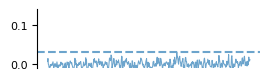

In [12]:
fig, ax = plt.subplots(figsize=(2.8,.9))
ax.plot(dc_r,c=col_r,linewidth=0.75)
ax.axhline(np.max(dc_r),linestyle='--',c=col_r)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.set_xticks([])
ax.tick_params(labelsize=8)
ax.set_ylim((-0.01,0.14))
plt.tight_layout()
plt.savefig(path_figures+'dc_r.pdf', transparent=True, format="PDF")
plt.show()

In [13]:
window_length=150 #Choosing the parameter of our analysis
time_interval=1 #We shift the window of only one time steps
dcorr=dict()

#For each condition we compute the dynamic correlation 
for sound in sound_list:
    dcorr[sound]=[]
    mat=[]

    #For each window, the average correlation
    for i in np.arange(0,len(ap_matrix[sound][0,:])-window_length, time_interval):
        
        #We append the average inter-subject correlation for each time-windows
        dcorr[sound].append(np.mean(np.corrcoef(ap_matrix[sound][:,i:i+window_length])[np.triu_indices(19, k = 1)]))


The correlation is saved as dcorr_all_windowlength_timeinterval

In [ ]:
sv.saving(dcorr, path_results+'dcorr_all_'+str(window_length)+'_1')

In [ ]:
window_length=150
dcorr_all=sv.loading(path_results+'dcorr_all_'+str(window_length)+'_1')

Here we study the engagement, before in the highly correlated time-windows, then considering all the data.

First of all we create the array with the indices of high correlation, major than the maximum observed in resting state.

In [179]:

ind_all={}

for sound in sound_list:
    
    #The threshold correspond to the maximal correlation observed during resting state
    corr_thres_l=max(dcorr_all['rest'])
    aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
    ind_all[sound]=list(aa)


In [180]:
#Creating the final list of indices of interest (avoiding problems due to time-windows overlapping)

index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

mem={}
m=min(len(index_all['speech']), len(index_all['music']))
for sound in ['speech', 'music', 'rest']:
    #index_all[sound]=index_all[sound][:m]
    mem[sound]=len(index_all[sound])


Here I compute the engagement for speech and music for those instant of time in which the inter-subject correlation was higher than the max observed during resting state.

In [181]:
#dictionaire with the engagement of high-intersubject correlation windows
eng_simple={}

#dictionnaire with the length of the data along time direction
lenn={}

for sound in sound_list:
    
    #dictionnaire with sound - subject
    eng_simple[sound]={}
    lenn[sound]={}

    for subject in subject_list:

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)

        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        lenn[sound][subject]=len(avalanches['Zbin'][:,0])

        #binarized data, only indices selected before
        aval=avalanches['Zbin'][index_all[sound],:]               

        #sum across time                                  
        engagementt=np.sum(aval, axis=0)
        eng_simple[sound][subject]=engagementt
        

Here engagement considering all the time points

In [182]:

#The engagement considering all the data and not only the time-windows with high intersubject correlation
eng_simpla={}

for sound in sound_list:
    
    eng_simpla[sound]={}
    
    for subject in subject_list:

        #the threshold is derived as the 99th percentile of the data
        thres = np.percentile(zdata[subject]['rest'], 99)

        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches = av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        
        #binarized data
        aval = avalanches['Zbin']    

        #sum across time                        
        engagementt = np.sum(aval, axis=0)
        eng_simpla[sound][subject] = engagementt

Here we compute the significance of the difference between the engagement of two different conditions, usign the hyper-geometric distribution

In [183]:
peng_dyn={}
for sound in ['speech', 'music']:
    peng_dyn[sound]={}
    for sub in subject_list:
        peng_dyn[sound][sub]=p_eng(eng_simple[sound][sub], eng_simpla['rest'][sub], mem[sound], lenn['rest'][sub]) 

In [184]:
for sound in ['speech_music']:
    peng_dyn[sound]={}
    for sub in subject_list:
        peng_dyn[sound][sub]=p_eng(eng_simple['speech'][sub], eng_simple['music'][sub], mem['speech'], mem['music']) 

In [185]:
peng={}
for sound in ['speech', 'music']:
    peng[sound]={}
    for sub in subject_list:
        peng[sound][sub]=p_eng(eng_simpla[sound][sub], eng_simpla['rest'][sub], lenn[sound][sub], lenn['rest'][sub]) 


In [186]:
sv.saving(peng_dyn, path_results + 'peng_dyn_bins2_dict_windowlength'+str(window_length))
sv.saving(peng, path_results + 'peng_bins2_dict_windowlength'+str(window_length))

In [187]:
peng_dyn=sv.loading(path_results + 'peng_dyn_bins2_dict_windowlength'+str(window_length))
peng=sv.loading(path_results + 'peng_bins2_dict_windowlength'+str(window_length))

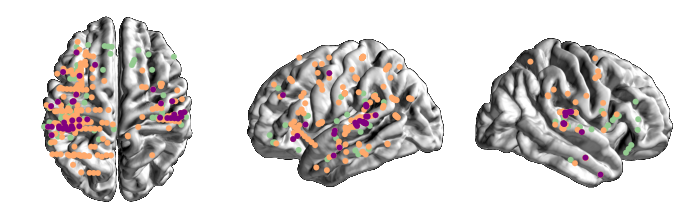

In [188]:

alpha=1
edgecolors='k'
size=70
linewidths=0.1
p_value = 0.05
enga={}
for sound in ['speech','music', 'ixi']:
    enga[sound]={}
    for subject in subject_list:
        pp=p_value/len(peng_dyn['speech'][subject][0])
                       
        if sound=='ixi':
            enga[sound][subject]=np.where(peng_dyn['speech'][subject][0]>1-pp,1,0)*np.where(peng_dyn['music'][subject][0]>1-pp,1,0)

        
        else:
            
            enga[sound][subject]=np.where(peng_dyn[sound][subject][0]>1-pp,1,0)




C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc', 'i':'purple'}

fig, ax= plt.subplots(1,3, figsize=(7,3))


for o, sound in enumerate(['speech','music','ixi']):
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates
                
            color=C1[sound[:1]]
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=color,linewidths=linewidths, alpha=(enga[sound][subject][left_i])*alpha)
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=color,linewidths=linewidths, alpha=(enga[sound][subject][right_i])*alpha)
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=color,linewidths=linewidths, alpha=(enga[sound][subject])*alpha)

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path_results+'brain_plot_p01_speechmusicvsrest_dyncorr_window150_slide1.png', dpi=600)

Counting the persentages for tables, supplementaries

In [196]:
print('speech vs rest high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech'][subject][0]>1-pp,1,0))/len(np.where(peng_dyn['speech'][subject][0]>1-pp,1,0))
print(aa/19)

print('rest vs speech high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech'][subject][1]>1-pp,1,0))/len(np.where(peng_dyn['speech'][subject][0]>1-pp,1,0))
print(aa/19)

print('music vs rest high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['music'][subject][0]>1-pp,1,0))/len(peng_dyn['speech'][subject][0])
print(aa/19)

print('rest vs music high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['music'][subject][1]>1-pp,1,0))/len(np.where(peng_dyn['speech'][subject][0]>1-pp,1,0))
print(aa/19)

print('music vs speech high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech_music'][subject][1]>1-pp,1,0))/len(peng_dyn['speech'][subject][0])
print(aa/19)


print('speech vs music high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech_music'][subject][0]>1-pp,1,0))/len(np.where(peng_dyn['speech'][subject][0]>1-pp,1,0))
print(aa/19)

speech vs rest high-corr
0.0386731311094334
rest vs speech high-corr
0.04576604584176563
music vs rest high-corr
0.08431697970228325
rest vs music high-corr
0.03812763820138844
music vs speech high-corr
0.06105663541876393
speech vs music high-corr
0.02397394921675062


In [198]:
print('speech vs rest high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech'][subject][0]>1-pp,1,0))
print(aa)

print('rest vs speech high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech'][subject][1]>1-pp,1,0))
print(aa)

print('music vs rest high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['music'][subject][0]>1-pp,1,0))
print(aa)

print('rest vs music high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['music'][subject][1]>1-pp,1,0))
print(aa)

print('music vs speech high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech_music'][subject][1]>1-pp,1,0))
print(aa)


print('speech vs music high-corr')
aa=0
for subject in subject_list:
    aa+=np.sum(np.where(peng_dyn['speech_music'][subject][0]>1-pp,1,0))
print(aa)

speech vs rest high-corr
100
rest vs speech high-corr
124
music vs rest high-corr
220
rest vs music high-corr
101
music vs speech high-corr
163
speech vs music high-corr
61


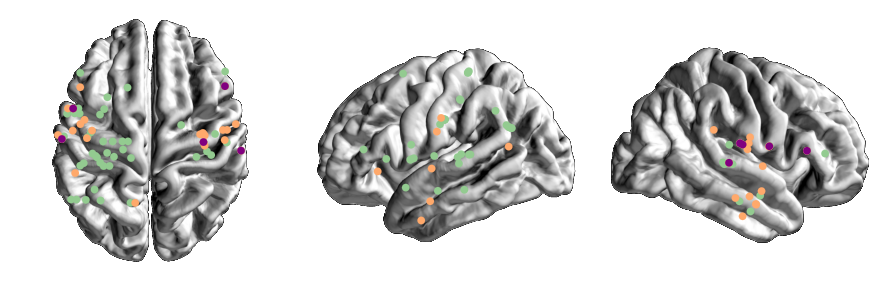

In [144]:

alpha=1
edgecolors='k'
size=30
linewidths=0.1
p_value = 0.05
enga={}
for sound in ['speech','music', 'ixi']:
    enga[sound]={}
    for subject in subject_list:
        pp=p_value/len(peng_dyn['speech'][subject][0])
                       
        if sound=='ixi':
            enga[sound][subject]=np.where(peng['speech'][subject][0]>1-pp,1,0)*np.where(peng['music'][subject][0]>1-pp,1,0)

        
        else:
            
            enga[sound][subject]=np.where(peng[sound][subject][0]>1-pp,1,0)




C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc', 'i':'purple'}

fig, ax= plt.subplots(1,3, figsize=(9,3))


for o, sound in enumerate(['speech','music','ixi']):
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates
                
            color=C1[sound[:1]]
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='o',linewidths=linewidths, alpha=(enga[sound][subject][left_i])*alpha)
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='o',linewidths=linewidths, alpha=(enga[sound][subject][right_i])*alpha)
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='o',linewidths=linewidths, alpha=(enga[sound][subject])*alpha)

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path_results+'brain_plot_p01_speechmusicvsrest.png', dpi=600)


## here the same plot but only for speech and music in direct comparison

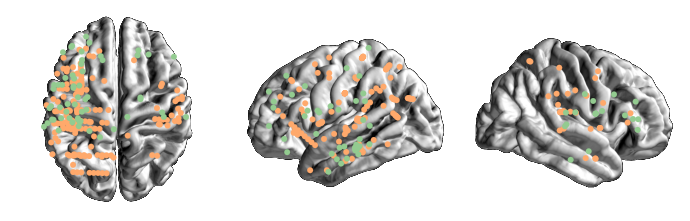

In [194]:

alpha=1
edgecolors='k'
size=70
linewidths=0.1
p_value = 0.05
enga={}
for sound in ['speech','music']:
    enga[sound]={}
    for subject in subject_list:
        pp=p_value/len(peng_dyn['speech'][subject][0])
                       
        if sound=='speech':
            enga[sound][subject]=np.where(peng_dyn['speech_music'][subject][0]>1-pp,1,0)

        
        elif sound=='music':
            
            enga[sound][subject]=np.where(peng_dyn['speech_music'][subject][1]>1-pp,1,0)




C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc', 'i':'purple'}

fig, ax= plt.subplots(1,3, figsize=(7,3))


for o, sound in enumerate(['music','speech']):
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates
                
            color=C1[sound[:1]]
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=color,linewidths=linewidths, alpha=(enga[sound][subject][left_i])*alpha)
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=color,linewidths=linewidths, alpha=(enga[sound][subject][right_i])*alpha)
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=color,linewidths=linewidths, alpha=(enga[sound][subject])*alpha)

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig('brain_plot_p01_speechmusicvsrest_alldata_plotsmtog.png', dpi=600)
